In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import random
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from torch.utils.data import WeightedRandomSampler

from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from transformers import get_scheduler

from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

## Load data

In [ ]:
project_directory = '/data'

messages.parquet  messages_v2.parquet  model-v1/  model-v2/  model-v3/  model-v4/  results/


In [ ]:
messages_path = f"{project_directory}/messages_v2.parquet"

In [ ]:
messages = pd.read_parquet(messages_path)
messages.shape

(10000, 5)

In [ ]:
messages.head(10)

,user,message,ts,seqid,event
0,ankur,hi,1.704172e+09,440734,0
1,XVampireX,heya,1.704172e+09,440735,0
2,XVampireX,"Several questions, starting with: How do I pla...",1.704172e+09,440736,0
3,XVampireX,"ah, nevermind",1.704172e+09,440737,0
4,ports-,anyone have trouble with browsers in Kubuntu n...,1.704172e+09,440738,0
5,frank23,ports-: what site do you have a problem with?,1.704172e+09,440739,0
6,ports-,frank23: like Kubuntu.org,1.704172e+09,440740,0
7,ports-,i cant see the menu tabs on it correctly,1.704172e+09,440741,0
8,frank23,ports-: you mean at the top of the page? works...,1.704172e+09,440742,0
9,ports-,nevermind,1.704172e+09,440743,0


In [ ]:
messages["event"].mean()

0.0108

## Prepare data for model training

In [ ]:
MESSAGE_SEP_TOKEN = "[MESSAGE]"

def combine_message_record(row):
  return f"{MESSAGE_SEP_TOKEN} [{row['user']}]: {row['message']}"

messages["message_record"] = messages.apply(combine_message_record, axis=1)

messages[:3]

,user,message,ts,seqid,event,message_record
0,ankur,hi,1.704172e+09,440734,0,[MESSAGE] [ankur]: hi
1,XVampireX,heya,1.704172e+09,440735,0,[MESSAGE] [XVampireX]: heya
2,XVampireX,"Several questions, starting with: How do I pla...",1.704172e+09,440736,0,"[MESSAGE] [XVampireX]: Several questions, star..."


### Split training data

In [ ]:
len(messages)

10000

In [ ]:
split_test_index = 9300
df_train = messages[:split_test_index]
df_test = messages[split_test_index:]

split_valid_index = 7200
df_train, df_valid = df_train[:split_valid_index], df_train[split_valid_index:]

df_train.shape, df_valid.shape, df_test.shape

((7200, 6), (2100, 6), (700, 6))

In [ ]:
df_train["event"].mean(), df_valid["event"].mean(), df_test["event"].mean()

(0.010972222222222222, 0.009047619047619047, 0.014285714285714285)

### Create data sets

In [ ]:
class TokenClassificationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, window_size, max_length=512):
        self.texts = dataframe["message_record"].tolist()
        self.labels = dataframe["event"].tolist()
        self.tokenizer = tokenizer
        self.window_size = window_size
        self.max_length = max_length

    def __len__(self):
        return len(self.texts) - self.window_size + 1

    def __getitem__(self, idx):
        text_window = self.texts[idx : idx + self.window_size]
        label_window = self.labels[idx : idx + self.window_size]
        positive_rate = np.mean(label_window)
        concatenated_text = "\n".join(text_window)
        last_message_end = len(concatenated_text)
        last_message_start = last_message_end - len(text_window[-1])

        encoding = self.tokenizer(
            concatenated_text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
            return_offsets_mapping=True,
        )
        offset_mapping = encoding.pop("offset_mapping")[0].tolist()

        # Calculate token-level labels
        labels = []
        last_message_mask = []
        for offset in offset_mapping:
            if offset == [0, 0]:
                labels.append(-100)  # Padding/special tokens
                last_message_mask.append(0)
                continue

            cum_message_length = 0
            for i, message in enumerate(text_window):
                cum_message_length += len(message) + 1  # `+ 1` is for "\n"
                if offset[0] <= cum_message_length:
                    labels.append(label_window[i])
                    break

            # Build mask to distiguish the last message
            if last_message_start <= offset[0] and offset[1] <= last_message_end:
                last_message_mask.append(1)
            else:
                last_message_mask.append(0)

        # Attach token labels
        encoding["labels"] = torch.tensor(labels, dtype=torch.long)
        encoding["last_message_mask"] = torch.tensor(last_message_mask, dtype=torch.long)
        encoding["positive_rate"] = positive_rate

        return {key: val.squeeze() for key, val in encoding.items()}

In [ ]:
# "bert-base-uncased"
# "bert-base-multilingual-cased" - multilingual data (~110M params)
# "xlm-roberta-base" - multilingual model (~270M params)
# "distilbert-base-uncased": faster, lighter (~66M params)
# distilbert-base-multilingual-cased

model_name = "xlm-roberta-base"

In [ ]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.truncation_side = "left"  # !!! The last message is the most important

In [ ]:
MESSAGE_WINDOW_SIZE = 15

train_dataset = TokenClassificationDataset(df_train, tokenizer, window_size=MESSAGE_WINDOW_SIZE)
valid_dataset = TokenClassificationDataset(df_valid, tokenizer, window_size=MESSAGE_WINDOW_SIZE)
test_dataset = TokenClassificationDataset(df_test, tokenizer, window_size=MESSAGE_WINDOW_SIZE)

In [ ]:
messages[messages["event"] > 0][:3]

,user,message,ts,seqid,event,message_record
428,_nelson_,"not yet, it's frustrating. maybe we should vid...",1.704172e+09,441162,1,"[MESSAGE] [_nelson_]: not yet, it's frustratin..."
429,simian_,I could help with that. want to do a quick scr...,1.704172e+09,441163,1,[MESSAGE] [simian_]: I could help with that. w...
430,_nelson_,"yeah, that would be great! when are you free?",1.704172e+09,441164,1,"[MESSAGE] [_nelson_]: yeah, that would be grea..."


In [ ]:
message_idx = 425
token_ids = train_dataset[message_idx]["input_ids"].numpy().tolist()
labels = train_dataset[message_idx]["labels"].numpy().tolist()
print(len(token_ids))
print(list(zip(token_ids, labels)))
# print(train_dataset[message_idx]["offset_mapping"].numpy().tolist())

512
[(0, -100), (378, 0), (78787, 0), (294, 0), (75930, 0), (268, 0), (378, 0), (12150, 0), (454, 0), (268, 0), (12, 0), (456, 0), (378, 0), (78787, 0), (294, 0), (75930, 0), (268, 0), (378, 0), (7, 0), (2822, 0), (76, 0), (268, 0), (12, 0), (35378, 0), (378, 0), (78787, 0), (294, 0), (75930, 0), (268, 0), (378, 0), (11193, 0), (5125, 0), (21231, 0), (268, 0), (12, 0), (101, 0), (8876, 0), (1681, 0), (454, 0), (12, 0), (114407, 0), (4, 0), (765, 0), (398, 0), (37842, 0), (154107, 0), (70, 0), (21640, 0), (20117, 0), (23009, 0), (538, 0), (32, 0), (378, 0), (78787, 1), (294, 1), (75930, 1), (268, 1), (378, 1), (454, 1), (8876, 1), (1681, 1), (454, 1), (268, 1), (12, 1), (959, 1), (14373, 1), (4, 1), (442, 1), (25, 1), (7, 1), (57357, 1), (1916, 1), (5, 1), (51139, 1), (642, 1), (5608, 1), (1202, 1), (11782, 1), (136, 1), (8, 1), (85779, 1), (903, 1), (25842, 1), (378, 1), (78787, 1), (294, 1), (75930, 1), (268, 1), (378, 1), (62318, 1), (66, 1), (454, 1), (268, 1), (12, 1), (87, 1), (58

In [ ]:
tokenizer.cls_token_id

0

In [ ]:
Counter(train_dataset[425]["labels"].numpy().tolist())

Counter({-100: 181, 0: 159, 1: 172})

In [ ]:
df_train[425 : 425 + MESSAGE_WINDOW_SIZE]["event"].mean()

0.4666666666666667

## Train the model

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=2)

# Add special token if needed
special_tokens_dict = {'additional_special_tokens': [MESSAGE_SEP_TOKEN]}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

In [ ]:
## Number of model params
sum(p.numel() for p in model.parameters())

277455362

### Train via a custom loop

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def seed_everything(seed: int = 97):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = (
        False  # Disable cuDNN benchmarking for deterministic results
    )

In [ ]:
def calc_sampling_weights(train_dataset, sampled_positive_frac):
    train_positive_rates = [train_dataset[i]["positive_rate"] for i in range(len(train_dataset))]
    positive_frac = np.mean([1.0 if rate > 0 else 0.0 for rate in train_positive_rates])
    print("Real positive frac:", positive_frac)
    negative_frac = 1.0 - positive_frac
    weight_pos = 1.0
    weight_neg = (positive_frac * weight_pos * (1 - sampled_positive_frac)) / (sampled_positive_frac * negative_frac)
    print(f"Sampled positive frac (targeted): {sampled_positive_frac}")
    print(f"Weight for negatives: {weight_neg}")
    return [weight_pos if rate > 0 else weight_neg for rate in train_positive_rates]

In [ ]:
def compute_auc(labels, logits, mask=-100):
    """
    Compute AUC-ROC score for logits with masking.

    Parameters:
    - labels: Tensor of true labels.
    - logits: Tensor of model outputs (logits).
    - mask: Can be an integer (ignore label) or a tensor (token mask).

    Returns:
    - AUC-ROC score for the filtered logits and labels.
    """
    if isinstance(mask, int):
        mask = labels != mask
    else:
        mask = mask.bool()
    labels = labels[mask].flatten().cpu().numpy()
    logits = logits[mask].detach().cpu()
    probs = torch.softmax(logits, dim=-1)[:, 1].numpy()
    return roc_auc_score(labels, probs)

In [ ]:
def weighted_loss(logits, labels, weight_mask=None, weight_factor=1.0, ignore_index=-100):
    """
    Compute cross-entropy loss with optional token weighting.

    Parameters:
    - logits: Tensor of shape [batch_size, seq_length, num_classes].
    - labels: Tensor of shape [batch_size, seq_length].
    - weight_mask: Tensor of shape [batch_size, seq_length], binary mask for higher weight tokens, or None.
    - weight_factor: Weight multiplier for higher weight tokens.
    - ignore_index: Index to ignore in loss computation (e.g., padding tokens).

    Returns:
    - Weighted cross-entropy loss.
    """
    # Reshape logits and labels
    logits = logits.view(-1, logits.size(-1))  # [batch_size * seq_length, num_classes]
    labels = labels.view(-1)                   # [batch_size * seq_length]

    # Compute standard cross-entropy loss
    loss = torch.nn.functional.cross_entropy(
        logits, labels, ignore_index=ignore_index, reduction="none",
    )  # Per-token loss: [batch_size * seq_length]

    # Apply weights if weight_mask is provided
    if weight_mask is not None:
        weight_mask = weight_mask.view(-1).float()  # [batch_size * seq_length]
        weights = torch.ones_like(weight_mask)
        weights[weight_mask.bool()] *= weight_factor
        loss *= weights  # Apply token weights

    # Compute the mean loss, ignoring the ignored tokens
    valid_indices = labels != ignore_index
    return loss[valid_indices].mean()

In [ ]:
def evaluate(model, data_loader, device, last_message_weight):
    """
    Evaluate model on validation data.
    """
    model.eval()
    valid_loss = 0
    all_logits, all_labels, last_message_masks = [], [], []
    with torch.no_grad():
        for batch in data_loader:
            batch.pop("positive_rate")
            last_message_mask = batch.pop("last_message_mask").to(device)

            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            labels = batch["labels"]

            loss = weighted_loss(
                logits=logits,
                labels=labels,
                weight_mask=last_message_mask,
                weight_factor=last_message_weight,
                ignore_index=-100,
            )
            valid_loss += loss.item()

            all_logits.append(logits)
            all_labels.append(labels)
            last_message_masks.append(last_message_mask)

    # Concatenate logits and labels across batches
    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    last_message_masks = torch.cat(last_message_masks, dim=0)

    # Metrics
    valid_auc = compute_auc(all_labels, all_logits)
    valid_auc_last_message = compute_auc(all_labels, all_logits, last_message_masks)

    return valid_loss / len(data_loader), valid_auc, valid_auc_last_message

In [ ]:
def train_model(
    model,
    train_loader,
    valid_loader,
    num_epochs,
    lr,
    device,
    last_message_weight,
    patience,
):
    """
    Train and evaluate the model.
    """
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = len(train_loader) * num_epochs
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    best_valid_auc = float('-inf')
    best_model_state = None
    no_improve_epochs = 0

    # Metrics tracking
    train_losses, valid_losses = [], []
    train_auc_scores, valid_auc_scores = [], []
    train_auc_lm_scores, valid_auc_lm_scores = [], []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_logits, all_labels, last_message_masks = [], [], []

        for batch in train_loader:
            batch.pop("positive_rate")
            last_message_mask = batch.pop("last_message_mask").to(device)

            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            labels = batch["labels"]

            loss = weighted_loss(
                logits=logits,
                labels=labels,
                weight_mask=last_message_mask,
                weight_factor=last_message_weight,
                ignore_index=-100
            )

            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

            all_logits.append(logits)
            all_labels.append(labels)
            last_message_masks.append(last_message_mask)

        # Compute training metrics
        train_loss /= len(train_loader)
        all_logits = torch.cat(all_logits, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        last_message_masks = torch.cat(last_message_masks, dim=0)

        train_auc = compute_auc(all_labels, all_logits)
        train_auc_lm = compute_auc(all_labels, all_logits, last_message_masks)

        # Append metrics
        train_losses.append(train_loss)
        train_auc_scores.append(train_auc)
        train_auc_lm_scores.append(train_auc_lm)

        # Evaluate on validation set
        valid_loss, valid_auc, valid_auc_lm = evaluate(
            model,
            valid_loader,
            device,
            last_message_weight,
        )
        valid_losses.append(valid_loss)
        valid_auc_scores.append(valid_auc)
        valid_auc_lm_scores.append(valid_auc_lm)

        # Print epoch summary
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train AUC-ROC: {train_auc:.4f}, Train [LM] AUC-ROC: {train_auc_lm:.4f}")
        print(f"Valid Loss: {valid_loss:.4f}, Valid AUC-ROC: {valid_auc:.4f}, Valid [LM] AUC-ROC: {valid_auc_lm:.4f}")

        # Check Early Stopping
        if valid_auc_lm > best_valid_auc:
            best_valid_auc = valid_auc_lm
            best_model_state = model.state_dict()  # Save the best model state
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break


    # Restore the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print("Training complete!")

    return train_losses, valid_losses, train_auc_scores, valid_auc_scores, train_auc_lm_scores, valid_auc_lm_scores

In [ ]:
batch_size = 46
num_epochs = 16
lr = 1e-6
last_message_weight = 3.0
patience = 3
sampled_positive_frac = 0.12

In [ ]:
sampling_weights = calc_sampling_weights(train_dataset, sampled_positive_frac)
sampler = WeightedRandomSampler(sampling_weights, num_samples=len(train_dataset), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Real positive frac: 0.035346507097133315
Sampled positive frac (targeted): 0.12
Weight for negatives: 0.2687055202923639


In [ ]:
# Start training

seed_everything()

train_metrics = train_model(
    model,
    train_loader,
    valid_loader,
    num_epochs=num_epochs,
    lr=lr,
    device=device,
    last_message_weight=last_message_weight,
    patience=patience,
)

Epoch 1/16
Train Loss: 0.4344, Train AUC-ROC: 0.5648, Train [LM] AUC-ROC: 0.5628
Valid Loss: 0.0338, Valid AUC-ROC: 0.9504, Valid [LM] AUC-ROC: 0.8881
Epoch 2/16
Train Loss: 0.0633, Train AUC-ROC: 0.9671, Train [LM] AUC-ROC: 0.9554
Valid Loss: 0.0115, Valid AUC-ROC: 0.9939, Valid [LM] AUC-ROC: 0.9762
Epoch 3/16
Train Loss: 0.0295, Train AUC-ROC: 0.9945, Train [LM] AUC-ROC: 0.9816
Valid Loss: 0.0101, Valid AUC-ROC: 0.9918, Valid [LM] AUC-ROC: 0.9689
Epoch 4/16
Train Loss: 0.0173, Train AUC-ROC: 0.9984, Train [LM] AUC-ROC: 0.9926
Valid Loss: 0.0096, Valid AUC-ROC: 0.9898, Valid [LM] AUC-ROC: 0.9687
Epoch 5/16
Train Loss: 0.0119, Train AUC-ROC: 0.9994, Train [LM] AUC-ROC: 0.9952
Valid Loss: 0.0091, Valid AUC-ROC: 0.9876, Valid [LM] AUC-ROC: 0.9608
Early stopping triggered after 5 epochs.
Training complete!


## Save the model

In [ ]:
model_directory = f"{project_directory}/model-v5"
model.save_pretrained(model_directory)
tokenizer.save_pretrained(model_directory)

('/content/gdrive/My Drive/dev/monadical/model-v4/tokenizer_config.json',
 '/content/gdrive/My Drive/dev/monadical/model-v4/special_tokens_map.json',
 '/content/gdrive/My Drive/dev/monadical/model-v4/sentencepiece.bpe.model',
 '/content/gdrive/My Drive/dev/monadical/model-v4/added_tokens.json',
 '/content/gdrive/My Drive/dev/monadical/model-v4/tokenizer.json')

In [ ]:
# Load model
model = AutoModelForTokenClassification.from_pretrained(model_directory).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_directory)
tokenizer.truncation_side = "left"

## Binarization threshold

In [ ]:
def score_data(model, data_loader, device):
    model.eval()
    all_scores, all_labels = [], []

    with torch.no_grad():
        for batch in valid_loader:
            batch.pop("positive_rate", None)
            last_message_mask = batch.pop("last_message_mask").to(device)

            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits  # Shape: [batch_size, seq_length, num_classes]
            labels = batch["labels"]  # Shape: [batch_size, seq_length]

            # Extract positive class probabilities
            scores = torch.softmax(logits, dim=-1)[..., 1]  # Positive class probabilities
            batch_size = labels.size(0)

            # Process scores and labels for each input text
            for i in range(batch_size):
                # Mask scores and labels for the current input
                current_mask = last_message_mask[i].bool()
                current_scores = scores[i][current_mask]
                current_labels = labels[i][current_mask]

                # Average the scores for the last message
                if current_scores.numel() > 0:
                    all_scores.append(current_scores.mean().item())
                    all_labels.append(current_labels[0].item())  # First valid label

    # Convert collected scores and labels to numpy arrays
    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)

    if len(all_scores) == 0 or len(all_labels) == 0:
        raise ValueError("No valid scores or labels found in the validation set.")

    return all_scores, all_labels

In [ ]:
def find_best_threshold(model, data_loader, device):
    """
    Find the best binarization threshold for the model on the validation set,
    averaging scores for the last message tokens per input text.

    Parameters:
    - model: Trained model.
    - data_loader: DataLoader.
    - device: Device (CPU/GPU) to run the model.

    Returns:
    - Best threshold and corresponding F1-score.
    """
    all_scores, all_labels = score_data(model, data_loader, device)
    # Iterate over thresholds to find the best one
    thresholds = np.linspace(0, 1, 1001)
    best_f1 = 0
    best_threshold = 0
    for threshold in thresholds:
        predictions = (all_scores >= threshold).astype(int)
        f1 = f1_score(all_labels, predictions, pos_label=1, average="binary")
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1, all_scores, all_labels

In [ ]:
# Calculate the best threshold
best_threshold, best_f1, valid_scores, valid_labels = find_best_threshold(model, valid_loader, device)
print(f"Best Threshold (VALID): {best_threshold}, Best F1-Score (VALID): {best_f1}")

Best Threshold (VALID): 0.961, Best F1-Score (VALID): 0.7741935483870968


In [ ]:
def print_f1_prec_recall(threshold, scores, labels):
  predictions = (scores >= threshold).astype(int)
  f1 = f1_score(labels, predictions, pos_label=1, average="binary")
  precision = precision_score(labels, predictions)
  recall = recall_score(labels, predictions)

  print(f"F1-Score: {f1}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")

In [ ]:
threshold = 0.01
print(f"VALID, threshold={threshold}:")
print_f1_prec_recall(threshold, valid_scores, valid_labels)

VALID, threshold=0.01:
F1-Score: 0.6956521739130435
Precision: 0.5925925925925926
Recall: 0.8421052631578947


In [ ]:
threshold = 0.03
print(f"VALID, threshold={threshold}:")
print_f1_prec_recall(threshold, valid_scores, valid_labels)

VALID, threshold=0.03:
F1-Score: 0.6666666666666666
Precision: 0.6086956521739131
Recall: 0.7368421052631579


In [ ]:
threshold = 0.9
print(f"VALID, threshold={threshold}:")
print_f1_prec_recall(threshold, valid_scores, valid_labels)

VALID, threshold=0.9:
F1-Score: 0.75
Precision: 0.9230769230769231
Recall: 0.631578947368421


## TEST set

Find AUC-ROC (last message) and F1 (after binarization)

In [ ]:
test_scores, test_labels = score_data(model, test_loader, device)

In [ ]:
threshold = 0.01
predictions = (test_scores >= threshold).astype(int)
f1_test = f1_score(test_labels, predictions, pos_label=1, average="binary")
precision_test = precision_score(test_labels, predictions)
recall_test = recall_score(test_labels, predictions)

print(f"F1-Score (TEST): {f1_test}")
print(f"Precision (TEST): {precision_test}")
print(f"Recall (TEST): {recall_test}")

F1-Score (TEST): 0.6956521739130435
Precision (TEST): 0.5925925925925926
Recall (TEST): 0.8421052631578947


In [ ]:
def get_score_for_entry(model, dataset_entry, device):
    """
    Compute the average score for the last message in a specific dataset entry.

    Parameters:
    - model: Trained model.
    - dataset_entry: A single entry from the dataset.
    - device: Device (CPU/GPU) to run the model.

    Returns:
    - Average score for the last message tokens in the input.
    """
    model.eval()
    with torch.no_grad():
        # Remove "positive_rate" as it's not required for the model
        dataset_entry.pop("positive_rate", None)

        # Convert all values to tensors and move to the device
        dataset_entry = {
            k: torch.tensor(v).unsqueeze(0).to(device) if not isinstance(v, torch.Tensor) else v.unsqueeze(0).to(device)
            for k, v in dataset_entry.items()
        }

        # Extract "last_message_mask" and "labels" from the entry
        last_message_mask = dataset_entry.pop("last_message_mask").bool()
        labels = dataset_entry.pop("labels")

        # Forward pass
        outputs = model(**dataset_entry)
        logits = outputs.logits  # Shape: [1, seq_length, num_classes]

        # Extract scores for the positive class (class 1)
        scores = torch.softmax(logits, dim=-1)[..., 1]  # Positive class probabilities

        # Filter scores using the last message mask
        last_message_scores = scores[0][last_message_mask[0]]

        if last_message_scores.numel() > 0:
            average_score = last_message_scores.mean().item()
        else:
            average_score = None  # No valid scores for the last message

    return average_score

In [ ]:
start_window = 0
for idx in range(start_window, start_window + MESSAGE_WINDOW_SIZE):
  # print("Entire window:", "\n".join(valid_dataset.texts[idx : idx + MESSAGE_WINDOW_SIZE]))
  print(f"Last message in the window: {test_dataset.texts[idx + MESSAGE_WINDOW_SIZE - 1]}")
  print(f"score: {get_score_for_entry(model, test_dataset[idx], device):.3f}")
  print()

Last message in the window: [MESSAGE] [MikeStyle]: ...
score: 0.000

Last message in the window: [MESSAGE] [godsmoke]: I don't know if ark supports that
score: 0.000

Last message in the window: [MESSAGE] [uniq]: it doesn't.
score: 0.000

Last message in the window: [MESSAGE] [MikeStyle]: even with the unrar plugin i installed?
score: 0.000

Last message in the window: [MESSAGE] [godsmoke]: who knows
score: 0.000

Last message in the window: [MESSAGE] [MikeStyle]: is there a plugin for it
score: 0.000

Last message in the window: [MESSAGE] [ChurcH_of_FOamY]: yea winsucks will produce more than 1 sound at a time but linux won't
score: 0.000

Last message in the window: [MESSAGE] [godsmoke]: I don't use password-protected files
score: 0.000

Last message in the window: [MESSAGE] [uniq]: i've never had it working.
score: 0.000

Last message in the window: [MESSAGE] [stisev]: Hi all
score: 0.000

Last message in the window: [MESSAGE] [stisev]: anyone here?
score: 0.000

Last message in the

In [ ]:
last_messages = []
scores = []

for idx in range(len(test_dataset)):
    last_messages.append(test_dataset.texts[idx + MESSAGE_WINDOW_SIZE - 1])
    scores.append(get_score_for_entry(model, test_dataset[idx], device))

test_message_scored_df = pd.DataFrame({
    "last_message": last_messages,
    "score": scores
})

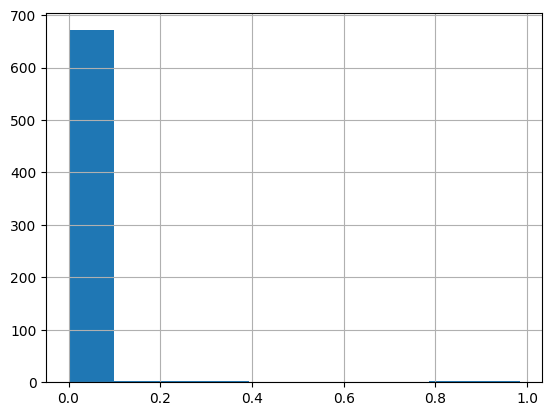

In [ ]:
test_message_scored_df["score"].hist(bins=10);

In [ ]:
test_message_scored_df["score"].describe()

,score
count,686.000000
mean,0.013937
std,0.092888
min,0.000188
25%,0.000336
50%,0.000477
75%,0.000893
max,0.983568


In [ ]:
df_test[df_test["event"] > 0].shape

(10, 6)

In [ ]:
threshold = 0.1

print(
    test_message_scored_df[test_message_scored_df["score"] > threshold]["last_message"].sample().tolist()[0]
)

[MESSAGE] [QueerAsFolk]: beunos tardes mi amigos y amigas!
